In [1]:
import numpy as np

from scipy import interpolate
import matplotlib.pyplot as plt
import copy
plt.style.use('../paper.mplstyle')
from tqdm import tqdm
from scipy.signal import find_peaks

import pycbc
from pycbc.types import load_frequencyseries
from pycbc import psd
import pycbc.psd
import pycbc.waveform
import pycbc.filter


/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [2]:
# PSD files are stored GZIPPEd, so need to GunZIP
# the `yes n` part of this commands skips if the file has already
# been unzipped in this directory
! yes n | gunzip -k model_AE_TDI1_optimistic.txt.gz
! yes n | gunzip -k model_AE_TDI1_pessimistic.txt.gz
! yes n | gunzip -k model_T_TDI1_optimistic.txt.gz
! yes n | gunzip -k model_T_TDI1_pessimistic.txt.gz
! yes n | gunzip -k model_AE_TDI1_SMOOTH_CUT_optimistic.txt.gz
! yes n | gunzip -k model_AE_TDI1_SMOOTH_optimistic.txt.gz
! yes n | gunzip -k model_AE_TDI1_SMOOTH_pessimistic.txt.gz

gzip: model_AE_TDI1_optimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe
gzip: model_AE_TDI1_pessimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe
gzip: model_T_TDI1_optimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe
gzip: model_T_TDI1_pessimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe
gzip: model_AE_TDI1_SMOOTH_CUT_optimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe
gzip: model_AE_TDI1_SMOOTH_optimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe
gzip: model_AE_TDI1_SMOOTH_pessimistic.txt already exists;	not overwritten
yes: standard output: Broken pipe


In [3]:
# Load the PSD models into memory:
a = load_frequencyseries('model_AE_TDI1_optimistic.txt')
# We don't actually need the very highest frequencies here
a = a[:1000001]
a = a.astype(np.complex128)
at = load_frequencyseries('model_T_TDI1_optimistic.txt')
at = at[:1000001]
at = at.astype(np.complex128)
b = load_frequencyseries('model_AE_TDI1_pessimistic.txt')
b = b[:1000001]
b = b.astype(np.complex128)
bt = load_frequencyseries('model_T_TDI1_pessimistic.txt')
bt = bt[:1000001]
bt = bt.astype(np.complex128)

# These two exists in the Portsmouth repo. and were made manually based on stuff in the next cells.
a1 = psd.from_txt(
    'model_AE_TDI1_SMOOTH_optimistic.txt',
    1000001,
    a.delta_f,
    a.delta_f,
    is_asd_file=False
)
b1 = psd.from_txt(
    'model_AE_TDI1_SMOOTH_pessimistic.txt',
    1000001,
    b.delta_f,
    b.delta_f,
    is_asd_file=False
)
a1 = a1.astype(np.complex128)
b1 = b1.astype(np.complex128)

inva = 1/a**0.5
invb = 1/b**0.5
inva1 = 1/a1**0.5
invb1 = 1/b1**0.5


/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)
/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: invalid value encountered in divide
  return self._data.__rtruediv__(other)


In [4]:
a_peaks = find_peaks(a)[0]

/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/pycbc/types/array.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype)


### This data was then used to create the smoothed files

/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


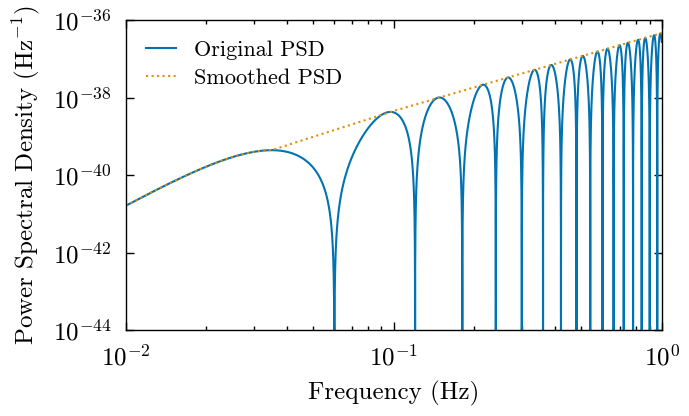

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(a.sample_frequencies, a, label='Original PSD')
ax.loglog(a1.sample_frequencies, a1, ':', label='Smoothed PSD')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density ($\mathrm{Hz}^{-1}$)')

ax.set_ylim([1E-44,1E-36])
ax.set_xlim([1E-2,1])

plt.legend(loc='upper left')

## Want to high-pass filter the "cut" PSD to avoid sharp effects in time-domain

In [6]:
a1c = copy.deepcopy(a1)
a1c = a1c.astype('float64')
a1c_smoothed = copy.deepcopy(a1c)
a1c_smoothed2 = pycbc.psd.estimate.interpolate(a1c_smoothed, 1E-8)

/home/gareth/miniconda3/envs/env_lisa_ew/lib/python3.10/site-packages/pycbc/types/array.py:864: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._data.astype(dtype)


In [7]:
num_smoothing_points = 3001
sigmoid = np.cos(np.linspace(0,np.pi,num_smoothing_points))
sigmoid = (sigmoid + 1)/2
data = np.log(a1c_smoothed2.data[10001 - num_smoothing_points:10001])
value = np.log(1E-36)
diff = value - data[-1]
data = data*0 + data[-1] + diff*sigmoid
data = np.exp(data)
a1c_smoothed2.data[10001 - num_smoothing_points:10001] = data
a1c_smoothed2.data[:10001 - num_smoothing_points] = 1E-36

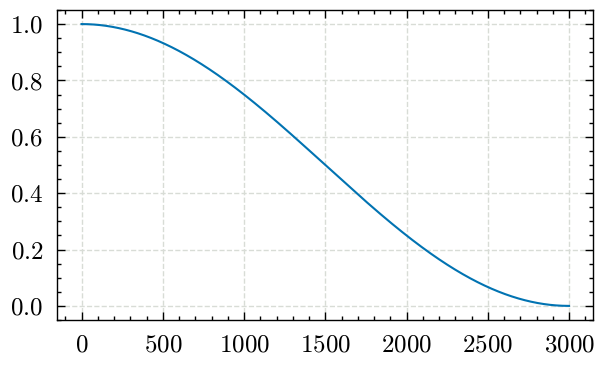

In [8]:
plt.plot(sigmoid)
plt.grid()

## Plot for Figure 1A

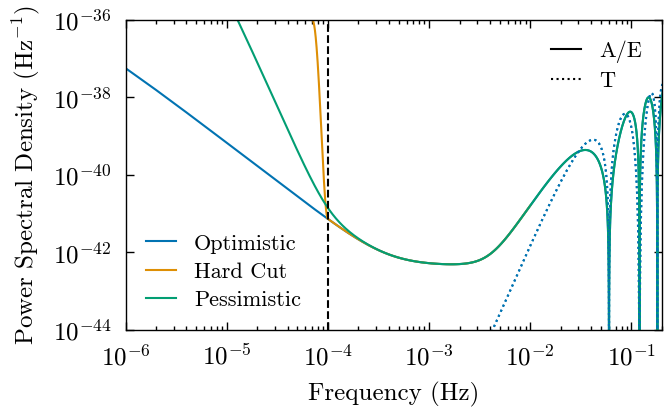

In [9]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig = plt.figure()
ax = fig.add_subplot(111)
ax.loglog(a.sample_frequencies, a, c=cycle[0], ls='-')
ax.loglog(at.sample_frequencies, at, c=cycle[0], ls=':')
ax.loglog(a1c_smoothed2.sample_frequencies[:1000000], a1c_smoothed2[:1000000], c=cycle[1], ls='-')
ax.loglog(b.sample_frequencies, b, c=cycle[2], ls='-')
ax.loglog(bt.sample_frequencies, bt, c=cycle[0], ls=':')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density ($\mathrm{Hz}^{-1}$)')
ax.tick_params()

# Generate some fake lines to make a legend
line1s = []
line1s.append(ax.plot([],[], linestyle='-', c='k')[0])
line1s.append(ax.plot([],[], linestyle=':', c='k')[0])
leg1_aet = ax.legend(line1s, ['A/E', 'T'], loc='upper right')

line2s = []
label2s = ['Optimistic', 'Hard Cut', 'Pessimistic']
for iii in range(3):
    line2s.append(ax.plot([],[],c=cycle[iii], ls='-')[0])
ax.legend(line2s, label2s, loc='lower left')
ax.add_artist(leg1_aet)

ax.set_ylim([1E-44,1E-36])
ax.set_xlim([1E-6,2E-1])
ax.loglog([1E-4,1E-4], [1E-44,1E-36], 'k--')


## Plot for Figure 1B

Now need to create the strain plot. Do this by empirically computing the response function from A,E,T to h(t) and applying that to the A,E,T PSDs.

We have commented out the following computation, and have instead provided the frequency response function as a file. This saves time when running this notebook.

In [10]:
# Constructing the average response from h(t) -> A,E,T,

def get_response_function(m):
    if m > 1E7:
        delta_f = 1. / (131072*32)
        freq=1/64.
    else:
        delta_f = 1. / (131072*2)
        freq = 1
    low_freq_cutoff = max(1e-06, delta_f)
    nominal_distance = 2000
        
    
    for count in tqdm(range(1000)):
        shared_waveform_LISA = {
            'spin1z':0,
            'spin2z':0,
            'delta_f':delta_f,
            'distance':nominal_distance,
            'f_lower':low_freq_cutoff,
        }

        m1=m
        m2=m
        
        coa_phase=np.random.uniform(0, np.pi * 2)
        inclination=np.arccos(np.random.uniform(0,1))
        polarization=np.random.uniform(0, np.pi * 2)
        eclipticlatitude=np.arccos(np.random.uniform(0,1))
        eclipticlongitude=np.random.uniform(0, np.pi * 2)


        wf = pycbc.waveform.get_fd_det_waveform(
                **shared_waveform_LISA,
                mass1=m1,
                mass2=m2,
                f_final=freq,
                coa_phase=coa_phase,
                inclination=inclination,
                polarization=polarization,
                eclipticlatitude=eclipticlatitude,
                eclipticlongitude=eclipticlongitude,
                ifos=['LISA_A','LISA_E','LISA_T'],
                approximant='BBHX_PhenomD',
                t_obs_start=86400*3000,
                tc=0.95 * 86400 * 3000,
                tdi=1.5,
                t_offset=0,
        )

        wf2p, _ = pycbc.waveform.get_fd_waveform(
                **shared_waveform_LISA,
                mass1=m1,
                mass2=m2,
                f_final=freq,
                coa_phase=coa_phase,
                inclination=inclination,
                approximant='IMRPhenomD'
        )
        wfa = wf['LISA_A']
        wfe = wf['LISA_E']
        wft = wf['LISA_T']
        if count == 0:
            ratioa = 1./( abs(wf2p.data[:-1])/abs(wfa.data[:]) )
            ratioe = 1./( abs(wf2p.data[:-1])/abs(wfe.data[:]) )
            ratiot = 1./( abs(wf2p.data[:-1])/abs(wft.data[:]) )
        else:
            ratioa[:] = (ratioa[:] * count + 1./( abs(wf2p.data[:-1])/abs(wfa.data[:])) ) / (count+1)
            ratioe[:] = (ratioe[:] * count + 1./( abs(wf2p.data[:-1])/abs(wfe.data[:])) ) / (count+1)
            ratiot[:] = (ratiot[:] * count + 1./( abs(wf2p.data[:-1])/abs(wft.data[:])) ) / (count+1)
    
    return wfa.sample_frequencies, ratioa / 2**0.5, ratioe / 2**0.5, ratiot / 2**0.5


In [11]:
# outs4 = get_response_function(1E4)
# outs6 = get_response_function(1E6)
# outs8 = get_response_function(1E8)


In [12]:
# plt.loglog(outs4[0][1000:], outs4[1][1000:], label='A response correction')
# plt.loglog(outs4[0][1000:], outs4[2][1000:], label='E response correction')
# plt.loglog(outs4[0][1000:], outs4[3][1000:], label='T response correction')

# plt.loglog(outs6[0][55:900], outs6[1][55:900], label='A response correction')
# plt.loglog(outs6[0][55:900], outs6[2][55:900], label='E response correction')
# plt.loglog(outs6[0][55:900], outs6[3][55:900], label='T response correction')

# plt.loglog(outs8[0][:800], outs8[1][:800], label='A response correction')
# plt.loglog(outs8[0][:800], outs8[2][:800], label='E response correction')
# plt.loglog(outs8[0][:800], outs8[3][:800], label='T response correction')

# plt.legend(loc='lower right')

In [13]:
# aa = np.zeros([len(outs4[0])-1000+845+800,2])
# aa[:800,0] = outs8[0][:800]
# aa[:800,1] = outs8[1][:800]
# aa[800:800+845,0] = outs6[0][55:900]
# aa[800:800+845,1] = outs6[1][55:900]
# aa[800+845:,0] = outs4[0][1000:]
# aa[800+845:,1] = outs4[1][1000:]

# tt = np.zeros([len(outs4[0])-1000+845+800,2])
# tt[:800,0] = outs8[0][:800]
# tt[:800,1] = outs8[3][:800]
# tt[800:800+845,0] = outs6[0][55:900]
# tt[800:800+845,1] = outs6[3][55:900]
# tt[800+845:,0] = outs4[0][1000:]
# tt[800+845:,1] = outs4[3][1000:]

# plt.loglog(aa[:,0], aa[:,1])
# plt.loglog(tt[:,0], tt[:,1])
# plt.legend(loc='lower right')

# aainterp = interpolate.interp1d(aa[:,0], aa[:,1])
# ttinterp = interpolate.interp1d(tt[:,0], tt[:,1])


In [14]:
# Save the response functions to an external file
# ainterp_array = aainterp(a.sample_frequencies[:-100])
# np.savetxt('AE_response_function.txt', ainterp_array)
# tinterp_array = ttinterp(at.sample_frequencies[:-100])
# np.savetxt('T_response_function.txt', tinterp_array)

In [15]:
# Load the response functions from the external file
ainterp_array = np.genfromtxt('AE_response_function.txt')
tinterp_array = np.genfromtxt('T_response_function.txt')

Text(0, 0.5, 'Response function (FIXME: UNITS)')

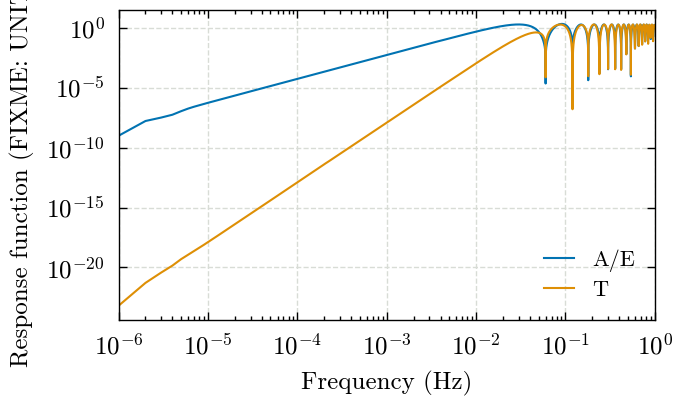

In [25]:
plt.loglog(a.sample_frequencies[:-100], ainterp_array, label='A/E')
plt.loglog(a.sample_frequencies[:-100], tinterp_array, label='T')
plt.legend(loc='lower right')
plt.grid(zorder=-100)
plt.xlim(1e-6, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Response function (FIXME: UNITS)")

/tmp/ipykernel_3841497/3555482724.py:9: RuntimeWarning: invalid value encountered in divide
  (a.sample_frequencies[b_peaks] * a.data[b_peaks]/(ainterp_array[b_peaks]**2))**0.5,
/tmp/ipykernel_3841497/3555482724.py:16: RuntimeWarning: invalid value encountered in divide
  (at.sample_frequencies[b_peaks] * at.data[b_peaks]/(tinterp_array[b_peaks]**2))**0.5,
/tmp/ipykernel_3841497/3555482724.py:37: RuntimeWarning: invalid value encountered in divide
  (b.sample_frequencies[b_peaks] * b[b_peaks]/(ainterp_array[b_peaks]**2))**0.5,


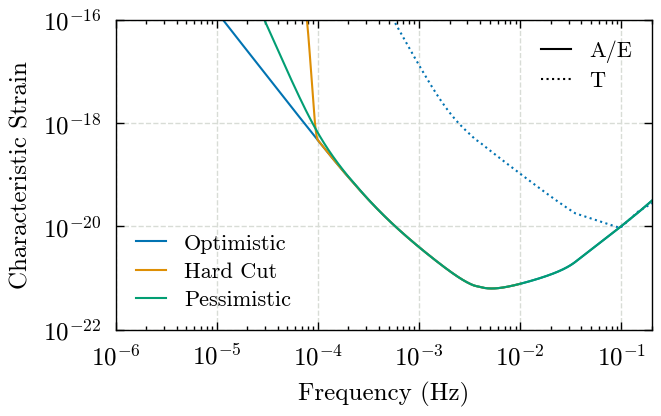

In [17]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure()
ax = fig.add_subplot(111)

b_peaks = np.append(np.arange(35042), a_peaks)
ax.loglog(
    a.sample_frequencies[b_peaks], 
    (a.sample_frequencies[b_peaks] * a.data[b_peaks]/(ainterp_array[b_peaks]**2))**0.5,
    c = cycle[0],
    ls='-'
)

ax.loglog(
    at.sample_frequencies[b_peaks], 
    (at.sample_frequencies[b_peaks] * at.data[b_peaks]/(tinterp_array[b_peaks]**2))**0.5,
    c=cycle[0],
    ls=':'
)

# The smoothed PSD is at different sample frequencies than the model,
# so we interpolate the response function here
aainterp = interpolate.interp1d(
    at.sample_frequencies[:-100],
    ainterp_array
)
smoothed_interp_array = aainterp(a1c_smoothed2.sample_frequencies[:1000000])
ax.loglog(
    a1c_smoothed2.sample_frequencies[:1000000],
    (a1c_smoothed2.sample_frequencies[:1000000] * a1c_smoothed2[:1000000]/(smoothed_interp_array**2))**0.5,
    c=cycle[1],
    ls='-',
)

ax.loglog(
    b.sample_frequencies[b_peaks], 
    (b.sample_frequencies[b_peaks] * b[b_peaks]/(ainterp_array[b_peaks]**2))**0.5,
    c=cycle[2],
    ls='-',
)
#ax.loglog(a1c.sample_frequencies, a1c, label='Hard Cut')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Characteristic Strain')
ax.tick_params()

# Generate some fake things to make a legend
line1s = []
line1s.append(ax.plot([],[], linestyle='-', c='k')[0])
line1s.append(ax.plot([],[], linestyle=':', c='k')[0])
leg1_aet = ax.legend(line1s, ['A/E', 'T'], loc='upper right')

line2s = []
label2s = ['Optimistic', 'Hard Cut', 'Pessimistic']
for iii in range(3):
    line2s.append(ax.plot([],[],c=cycle[iii], ls='-')[0])
ax.legend(line2s, label2s, loc='lower left')
ax.add_artist(leg1_aet)

ax.set_ylim([1E-22,1E-16])
ax.set_xlim([1E-6,2E-1])
ax.loglog([1E-4,1E-4], [1E-44,1E-26], 'k--')
ax.grid(zorder=-100)


## Creating the PSD kernels

Now we begin the process of computing the zero-latency PSDs and the various plots associated with that.

In [18]:
inva[0] = 0
inva1[0] = 0
invb[0] = 0
invb1[0] = 0 

at = inva.to_timeseries()
at._epoch = 0
at.roll(100000*2)
at._epoch = -200000/2.

a1t = inva1.to_timeseries()
a1t._epoch = 0
a1t.roll(100000*2)
a1t._epoch = -200000/2.

bt = invb.to_timeseries()
bt._epoch = 0
bt.roll(100000*2)
bt._epoch = -200000/2.

b1t = invb1.to_timeseries()
b1t._epoch = 0
b1t.roll(100000*2)
b1t._epoch = -200000/2.



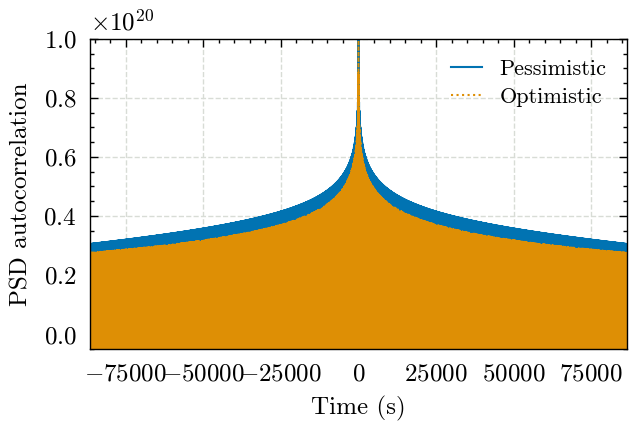

In [19]:
plt.plot(bt.sample_times, bt, label='Pessimistic')
plt.plot(at.sample_times, at, ':', label='Optimistic')
plt.legend(loc='upper right')
plt.ylim(-0.5E19,1E20)
plt.xlim(-86400,86400)
plt.xlabel('Time (s)')
plt.ylabel('PSD autocorrelation')
plt.grid(zorder=-100)

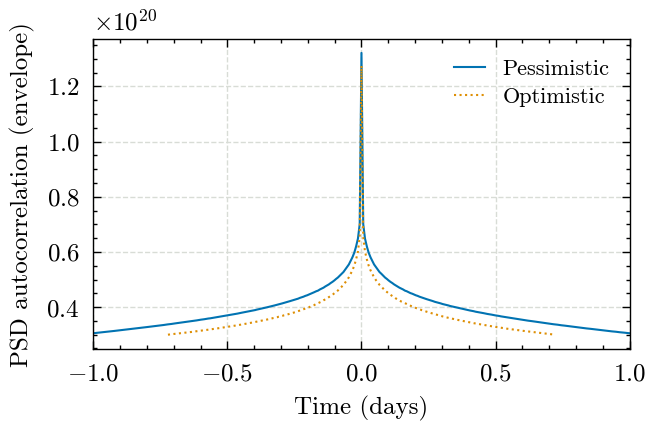

In [20]:
import scipy
idxes = scipy.signal.find_peaks(bt, height=0.3E20, distance=1000)[0]
plt.plot(bt.sample_times[idxes]/86400., (bt)[idxes], label='Pessimistic')
idxes = scipy.signal.find_peaks(at, height=0.3E20, distance=1000)[0]
plt.plot(at.sample_times[idxes]/86400., (at)[idxes], ':', label='Optimistic')

plt.xlim(-1,1)
plt.legend(loc='upper right')
plt.xlabel('Time (days)')
plt.ylabel('PSD autocorrelation (envelope)')
plt.grid(zorder=-100)

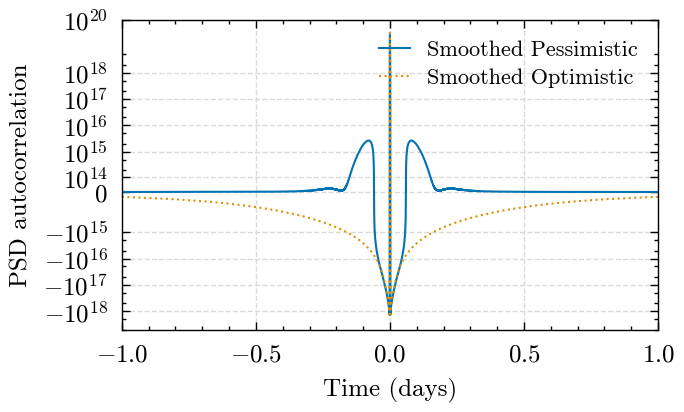

In [21]:
plt.plot(
    b1t.sample_times/86400,
    b1t,
    label='Smoothed Pessimistic'
)
plt.plot(
    a1t.sample_times/86400,
    a1t,
    linestyle=':',
    label='Smoothed Optimistic'
)
plt.legend(loc='upper right')
plt.yscale('asinh', linear_width=6E13)
plt.ylim(-0.5E19,1E20)
plt.xlim(-1,1)
plt.xlabel('Time (days)')
plt.ylabel('PSD autocorrelation')
plt.grid(zorder=-100)


## Now want the zero-phase filter PSDs

In [22]:
from pycbc.psd.lisa_pre_merger import generate_pre_merger_psds

In [23]:
dlen = 2592000 # Length in seconds
sample_rate = 0.2
delta_t = 5

psd_files = [
    ('./model_AE_TDI1_SMOOTH_optimistic.txt', 'Optimistic', 'a'),
    ('./model_AE_TDI1_SMOOTH_CUT_optimistic.txt', 'Hard Cut (Smoothed)', 'c'),
    ('./model_AE_TDI1_SMOOTH_pessimistic.txt', 'Pessimistic', 'b'),
]



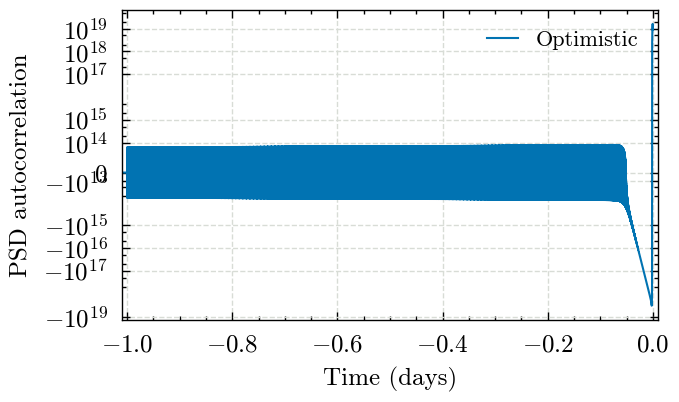

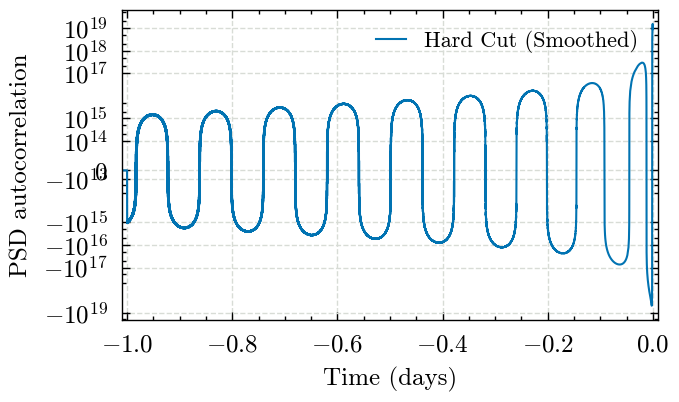

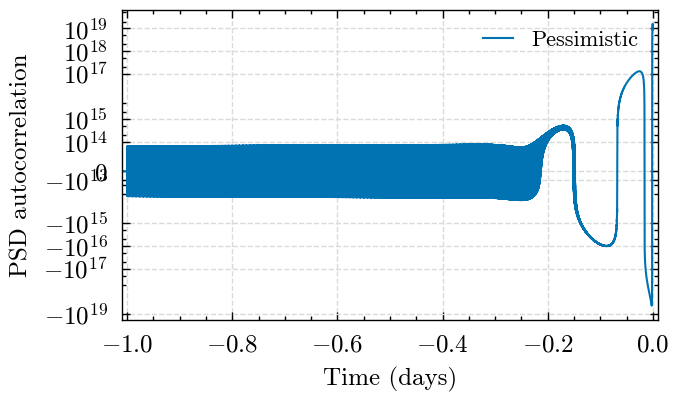

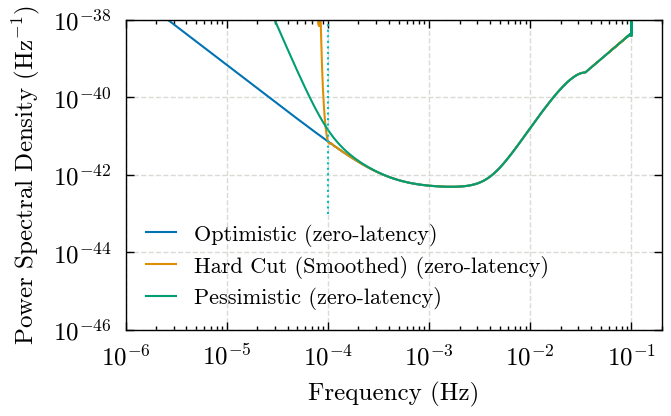

In [24]:
psd_vals = []

for psd_file, name, chh in psd_files:
    
    if name == 'Optimistic Smoothed LIMIT':
        f_lower = 1E-4
    else:
        f_lower = None

    zero_phase_kern = \
        generate_pre_merger_psds(
            psd_file,
            duration=dlen,
            sample_rate=sample_rate,
            kernel_length=int(86400*sample_rate),
        )

    plt.figure()
    plt.semilogy(
        (zero_phase_kern['TD'].sample_times - zero_phase_kern['TD'].sample_times[-1])/86400,
        zero_phase_kern['TD'],
        label=name
    )
    plt.legend(loc='upper right')
    plt.yscale('asinh', linear_width=1E13)
    plt.xlim(-1.01, 0.01)
    plt.xlabel('Time (days)')
    plt.ylabel('PSD autocorrelation')
    plt.grid(zorder=-100)
    
    psd_vals.append((
        zero_phase_kern['FD'].sample_frequencies,
        1./abs(zero_phase_kern['FD'])**2,
        f'{name} (zero-latency)'
    ))

plt.figure()
for vals in psd_vals:    
    plt.loglog(vals[0], vals[1], label=vals[2])
    plt.legend(loc='lower left')
plt.ylim([1E-46,1E-38])
plt.xlim([1E-6,2E-1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density ($\\mathrm{Hz}^{-1}$)')
plt.loglog([1E-4,1E-4], [1E-43,1E-36], 'c:')
plt.grid(zorder=-100)